In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
from spikingjelly.activation_based import neuron, functional, layer
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "0" # 仅使用第一块 GPU，解决兼容问题

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}") # 应该输出 1

PyTorch version: 2.9.1+cu128
CUDA available: True
Current device: NVIDIA GeForce RTX 3090
Device count: 1


In [3]:
# ----------------------------------------
# 1. 定义超参数和设置
# ----------------------------------------

T = 8             # 仿真总时长 (SNN 的关键参数)
BATCH_SIZE = 64   # 批处理大小
EPOCHS = 100       # 训练轮数 (为快速演示，设置较小)
LR = 1e-3         # 学习率
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"--- 实验设置 ---")
print(f"设备 (DEVICE): {DEVICE}")
print(f"仿真时长 (T): {T}")
print(f"批大小 (BATCH_SIZE): {BATCH_SIZE}")
print(f"训练轮数 (EPOCHS): {EPOCHS}")
print(f"------------------\n")

--- 实验设置 ---
设备 (DEVICE): cuda:0
仿真时长 (T): 8
批大小 (BATCH_SIZE): 64
训练轮数 (EPOCHS): 100
------------------



In [4]:
# ----------------------------------------
# 2. 加载和预处理 CIFAR10 数据集 (改进:解决过拟合问题)
# ----------------------------------------
print("正在加载 CIFAR10 数据集...")
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    # 【新增】随机裁剪：先填充4像素，再随机裁回32x32，这是CIFAR10防止过拟合的神器
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# 测试集不需要裁剪，保持原样
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("数据集加载完毕。")

正在加载 CIFAR10 数据集...
数据集加载完毕。


In [5]:
# ----------------------------------------
# 3. 定义改进后的卷积 SNN 模型 (加深版 - 3个卷积块)
# ----------------------------------------
class ImprovedCSNN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T

        self.net = nn.Sequential(
            # --- Block 1: 32x32 -> 16x16 ---
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            neuron.LIFNode(),
            nn.MaxPool2d(2),

            # --- Block 2: 16x16 -> 8x8 ---
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            neuron.LIFNode(),
            nn.MaxPool2d(2),

            # --- Block 3 (新增): 8x8 -> 4x4 ---
            # 通道数加倍到 128，提取更深层特征
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            neuron.LIFNode(),
            nn.MaxPool2d(2),
            
            nn.Flatten(),
            
            # --- FC 1 ---
            # 关键修改：输入维度变化
            # 图像经过3次2倍下采样：32 -> 16 -> 8 -> 4
            # 通道数现在是 128
            # 所以输入维度是 128 * 4 * 4
            nn.Linear(128 * 4 * 4, 256), 
            neuron.LIFNode(),
            
            # Dropout层: 防止过拟合
            nn.Dropout(0.2), 

            # --- FC 2 (Output) ---
            nn.Linear(256, 10)
        )

    def forward(self, x):
        functional.reset_net(self)
        outputs_over_time = []
        for t in range(self.T):
            out_t = self.net(x)
            outputs_over_time.append(out_t)
        
        return torch.stack(outputs_over_time).mean(dim=0)


In [8]:
# ----------------------------------------
# 4.初始化改进后的模型与优化器
# ----------------------------------------
# 记得重新运行这部分代码以应用新模型
model = ImprovedCSNN(T=T).to(DEVICE)
criterion = nn.CrossEntropyLoss()

# 重新初始化优化器 (因为模型参数变了)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 重新初始化调度器
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [9]:
# ----------------------------------------
# 5. 编写训练和评估循环
# ----------------------------------------

# --- 【修改】训练函数：移除 Batch 日志，返回 Loss 和 Acc ---
def train_epoch(epoch):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    end_time = time.time()
    avg_loss = total_loss / len(train_loader)
    acc = 100. * correct / total
    
    return avg_loss, acc, end_time - start_time

# --- 【修改】评估函数：返回 Loss 和 Acc ---
def test_epoch(epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    acc = 100. * correct / total
    return avg_loss, acc

In [10]:
# ----------------------------------------
# 6. 开始训练 
# ----------------------------------------
print("=== 开始训练 (100 Epochs) ===")

# 用于记录曲线数据的列表
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

for epoch in range(EPOCHS):
    # 训练
    train_loss, train_acc, duration = train_epoch(epoch)
    # 测试
    test_loss, test_acc = test_epoch(epoch)
    
    scheduler.step()
    # 记录数据
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # 保存最佳模型
    if test_acc > best_acc:
        best_acc = test_acc
    
    # 【修改】按 Epoch 打印简洁日志
    print(f"Epoch {epoch+1:03d}/{EPOCHS} | "
          f"Time: {duration:.1f}s | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

print(f"\n=== 训练完成 ===")
print(f"最佳测试集准确率: {best_acc:.2f}%")

=== 开始训练 (100 Epochs) ===
Epoch 001/100 | Time: 24.4s | Train Loss: 1.4622 Acc: 46.53% | Test Loss: 1.1227 Acc: 60.19%
Epoch 002/100 | Time: 20.3s | Train Loss: 1.1057 Acc: 60.24% | Test Loss: 0.9992 Acc: 64.78%
Epoch 003/100 | Time: 22.0s | Train Loss: 0.9519 Acc: 66.34% | Test Loss: 0.8665 Acc: 69.57%
Epoch 004/100 | Time: 20.7s | Train Loss: 0.8711 Acc: 69.26% | Test Loss: 0.8255 Acc: 70.85%
Epoch 005/100 | Time: 21.9s | Train Loss: 0.8048 Acc: 71.68% | Test Loss: 0.8011 Acc: 71.54%
Epoch 006/100 | Time: 24.0s | Train Loss: 0.7647 Acc: 73.17% | Test Loss: 0.7410 Acc: 73.94%
Epoch 007/100 | Time: 22.4s | Train Loss: 0.7300 Acc: 74.42% | Test Loss: 0.6936 Acc: 75.44%
Epoch 008/100 | Time: 23.3s | Train Loss: 0.7000 Acc: 75.55% | Test Loss: 0.6688 Acc: 76.57%
Epoch 009/100 | Time: 25.0s | Train Loss: 0.6818 Acc: 76.04% | Test Loss: 0.6689 Acc: 76.87%
Epoch 010/100 | Time: 25.7s | Train Loss: 0.6559 Acc: 77.12% | Test Loss: 0.6420 Acc: 77.67%
Epoch 011/100 | Time: 25.1s | Train Loss: 0.

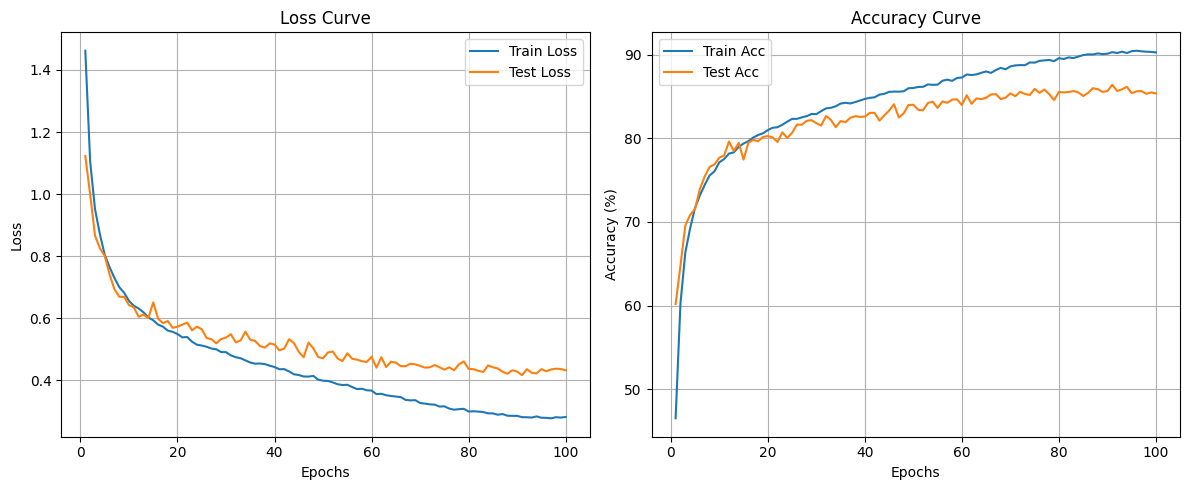

In [11]:
# ----------------------------------------
# 7. 绘制训练过程曲线
# ----------------------------------------
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# 子图 1: Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['test_loss'], label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 子图 2: Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Acc')
plt.plot(epochs_range, history['test_acc'], label='Test Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

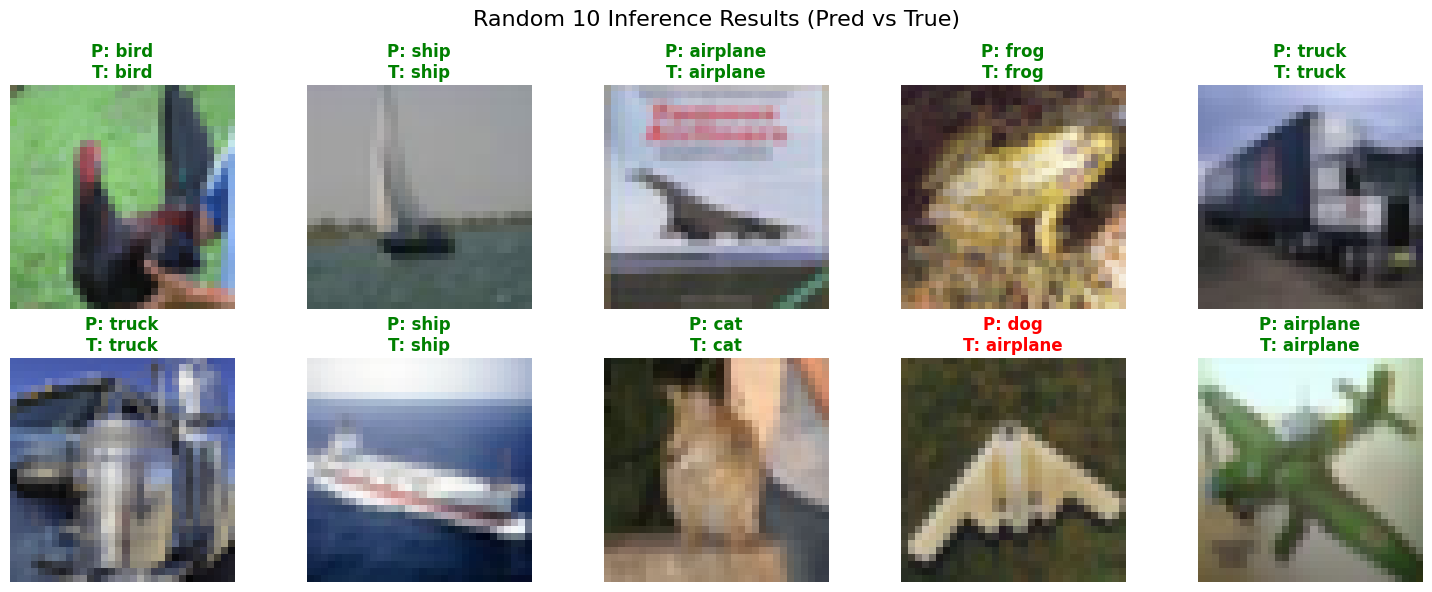

In [22]:
import matplotlib.pyplot as plt
import random
import numpy as np

# ----------------------------------------
# 8. 随机抽取 10 张图进行预测对比
# ----------------------------------------

# 【修复部分】获取 CIFAR10 的类别名称
# 方法一：直接从数据集对象中获取 (推荐)
class_names = train_dataset.classes

# 方法二：手动定义 (作为备选)
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()

# 获取一个 batch 的测试数据
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 随机选择 10 个索引
indices = random.sample(range(len(images)), 10)

# 准备画图
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Random 10 Inference Results (Pred vs True)', fontsize=16)

with torch.no_grad():
    for i, idx in enumerate(indices):
        img = images[idx]
        label = labels[idx].item()
        
        # 增加维度 [C, H, W] -> [1, C, H, W] 并送入设备
        img_input = img.unsqueeze(0).to(DEVICE)
        
        # 预测
        output = model(img_input)
        _, pred = output.max(1)
        pred_label = pred.item()
        
        # 反归一化以便显示图片 (Un-normalize)
        # image = image * std + mean
        img_disp = img.clone().cpu()
        for c in range(3):
            img_disp[c] = img_disp[c] * cifar_std[c] + cifar_mean[c]
        
        # 转换维度 [C, H, W] -> [H, W, C] 用于 matplotlib 显示
        img_disp = img_disp.permute(1, 2, 0).numpy()
        # 截断到 [0, 1] 防止显示警告
        img_disp = np.clip(img_disp, 0, 1)
        
        # 绘图
        ax = axes[i // 5, i % 5]
        ax.imshow(img_disp)
        
        # 设置标题颜色：绿色表示正确，红色表示错误
        color = 'green' if pred_label == label else 'red'
        
        # 现在这里可以正常运行了，因为 class_names 已经定义
        title_text = f"P: {class_names[pred_label]}\nT: {class_names[label]}"
        
        ax.set_title(title_text, color=color, fontsize=12, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()